## Dataset: F1 Database from ERGAST (Regression Problem) 

## Model Training

In [1]:
# import the pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to show all the columns of the dataframe in the notebeook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.ensemble import HistGradientBoostingRegressor

from catboost import CatBoostRegressor

from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error,
    r2_score)

from feature_engine.encoding import OrdinalEncoder

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor)

from sklearn.linear_model import LinearRegression

## Step 1: Data Transformation

### Preparing X and Y variables

In [2]:
df_race_finished = pd.read_csv('./processed_data/F1_race.csv')
df_race_finished

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,drivername,year,round,location,constructorname,status,race_age
0,1,1.0,10.0,58,39.0,2.0,218.300,Lewis_Hamilton,2008,1,Australian Grand Prix,McLaren,Finished,23
1,3,5.0,4.0,58,43.0,1.0,218.385,Heikki_Kovalainen,2008,1,Australian Grand Prix,McLaren,Finished,27
2,9,5.0,4.0,56,53.0,3.0,209.033,Lewis_Hamilton,2008,2,Malaysian Grand Prix,McLaren,Finished,23
3,8,3.0,6.0,56,19.0,7.0,208.031,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,McLaren,Finished,27
4,5,5.0,4.0,57,49.0,1.0,209.062,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,McLaren,Finished,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,18,13.0,0.0,55,NaN,NaN,NaN,Jo_Siffert,1964,2,Dutch Grand Prix,Brabham-BRM,+25 Laps,28
25896,10,13.0,0.0,55,NaN,NaN,NaN,Jo_Siffert,1965,6,Dutch Grand Prix,Brabham-BRM,+25 Laps,29
25897,9,13.0,0.0,79,NaN,NaN,NaN,Jo_Bonnier,1962,8,United States Grand Prix,Porsche,+21 Laps,32
25898,20,15.0,0.0,44,NaN,NaN,NaN,Horace_Gould,1954,5,British Grand Prix,Cooper,+46 Laps,36


In [3]:
X = df_race_finished.drop(columns=['points'],axis=1)

In [4]:
X.head()

,grid,position,laps,fastestLap,rank,fastestLapSpeed,drivername,year,round,location,constructorname,status,race_age
0,1,1.0,58,39.0,2.0,218.300,Lewis_Hamilton,2008,1,Australian Grand Prix,McLaren,Finished,23
1,3,5.0,58,43.0,1.0,218.385,Heikki_Kovalainen,2008,1,Australian Grand Prix,McLaren,Finished,27
2,9,5.0,56,53.0,3.0,209.033,Lewis_Hamilton,2008,2,Malaysian Grand Prix,McLaren,Finished,23
3,8,3.0,56,19.0,7.0,208.031,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,McLaren,Finished,27
4,5,5.0,57,49.0,1.0,209.062,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,McLaren,Finished,27


In [5]:
y = df_race_finished['points']

In [6]:
y

0        10.0
1         4.0
2         4.0
3         6.0
4         4.0
         ... 
25895     0.0
25896     0.0
25897     0.0
25898     0.0
25899     0.0
Name: points, Length: 25900, dtype: float64

In [7]:
# Create Column Transformer with 3 types of transformers
numerical_columns = X.select_dtypes(exclude="object").columns
categorical_columns = X.select_dtypes(include="object").columns

num_pipeline= Pipeline(
                steps=[ 
                        ("imputer",SimpleImputer(strategy="median")),
                        ("scaler",StandardScaler())
                      ]
                    )
                
cat_pipeline=Pipeline(
                steps=[
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("ordinal_encoder", OrdinalEncoder(encoding_method='arbitrary')),
                        ("scaler", StandardScaler(with_mean=False))
                ]
                    )        
                    
preprocessor=ColumnTransformer(
                [
                    ("num_pipeline",num_pipeline,numerical_columns),
                    ("cat_pipelines",cat_pipeline,categorical_columns)
                ]
                            )

In [8]:
X = preprocessor.fit_transform(X)

In [9]:
X.shape

(25900, 13)

## Step 2: Machine Learning Modelling  <a id="part9"></a>

### Train and Test Split  <a id="part9.1"></a>

In [10]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train.shape, X_test.shape

((18130, 13), (7770, 13))

### Model evaluation

In [11]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [12]:
models = {
            "Random Forest": RandomForestRegressor(),
            "Decision Tree": DecisionTreeRegressor(),
            "Gradient Boosting": GradientBoostingRegressor(),
            "Linear Regression": LinearRegression(),
            "Hist Gradient Boosting": HistGradientBoostingRegressor(),
            "XGBRegressor": XGBRegressor(),
            "CatBoosting Regressor": CatBoostRegressor(verbose=False),
            "AdaBoost Regressor": AdaBoostRegressor(),
        }

params={
            "Decision Tree": {
            'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            # 'splitter':['best','random'],
            # 'max_features':['sqrt','log2'],
                             },
    
            "Random Forest":{
            # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                 
            # 'max_features':['sqrt','log2',None],
            'n_estimators': [8,16,32,64,128,256]
                            },
    
            "Gradient Boosting":{
            # 'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
            'learning_rate':[.1,.01,.05,.001],
            'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
            # 'criterion':['squared_error', 'friedman_mse'],
            # 'max_features':['auto','sqrt','log2'],
            'n_estimators': [8,16,32,64,128,256]
                                },
    
            "Linear Regression":{},
    
            "Hist Gradient Boosting":{
            'learning_rate':[.1,.01,.05,.001],
            'max_depth': [6,8,10]
                },
     
            "XGBRegressor":{
            'learning_rate':[.1,.01,.05,.001],
            'n_estimators': [8,16,32,64,128,256]
                            },
    
            "CatBoosting Regressor":{
            'depth': [6,8,10],
            'learning_rate': [0.01, 0.05, 0.1],
            'iterations': [30, 50, 100]
                                    },  
    
            "AdaBoost Regressor":{
            'learning_rate':[.1,.01,0.5,.001],
            # 'loss':['linear','square','exponential'],
            'n_estimators': [8,16,32,64,128,256]
                                 }
    }

model_list = []
r2_list = []
params_list = []
mae_list = []
rmse_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    para=params[list(models.keys())[i]]
    gs = GridSearchCV(model,para,cv=3)
    gs.fit(X_train,y_train)
    params_list.append(gs.best_params_)
    model.set_params(**gs.best_params_)
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    mae_list.append(model_test_mae)
    rmse_list.append(model_test_rmse)
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Root Mean Squared Error: 0.1202
- Mean Absolute Error: 0.0127
- R2 Score: 0.9992
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3974
- Mean Absolute Error: 0.0359
- R2 Score: 0.9909


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4626
- Mean Absolute Error: 0.0308
- R2 Score: 0.9877


Gradient Boosting
Model performance for Training set
- Root Mean Squared Error: 0.2877
- Mean Absolute Error: 0.1153
- R2 Score: 0.9953
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3960
- Mean Absolute Error: 0.1278
- R2 Score: 0.9910


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 2.7267
- Mean Absolute Error: 1.8755
- R2 Score: 0.5763
-----------

### Results

In [13]:
df_results = pd.DataFrame(list(zip(model_list, r2_list,  rmse_list, mae_list, params_list)), columns=['Model Name', 'R2_Score', 'RMSE_Score', 'MAE_Score', 'Best_params']).sort_values(by=["R2_Score"],ascending=False).reset_index(drop=True)
df_results.index += 1
df_results

,Model Name,R2_Score,RMSE_Score,MAE_Score,Best_params
1,CatBoosting Regressor,0.993784,0.328464,0.086938,"{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}"
2,Hist Gradient Boosting,0.992673,0.356605,0.050733,"{'learning_rate': 0.1, 'max_depth': 10}"
3,XGBRegressor,0.991989,0.372888,0.046604,"{'learning_rate': 0.1, 'n_estimators': 256}"
4,Gradient Boosting,0.990964,0.396009,0.127775,"{'learning_rate': 0.1, 'n_estimators': 256, 'subsample': 0.85}"
5,Random Forest,0.990903,0.397358,0.035854,{'n_estimators': 256}
6,Decision Tree,0.987672,0.462567,0.030821,{'criterion': 'squared_error'}
7,AdaBoost Regressor,0.948496,0.945465,0.443406,"{'learning_rate': 0.01, 'n_estimators': 256}"
8,Linear Regression,0.577301,2.708560,1.855109,{}


## Step 3: Predictions

### CatBoosting Regressor  <a id="part9.6"></a>

In [14]:
Catboost_model = CatBoostRegressor(depth = 8, iterations = 100, learning_rate= 0.1, verbose=False)
Catboost_model = Catboost_model.fit(X_train, y_train)
y_pred = Catboost_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" r-squared score of the model is %.2f" %score)

 r-squared score of the model is 99.38


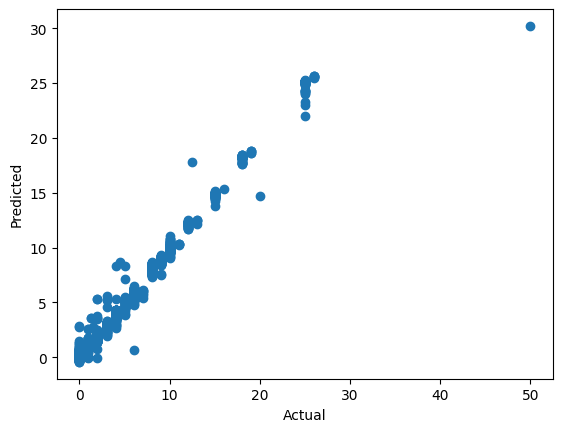

In [15]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

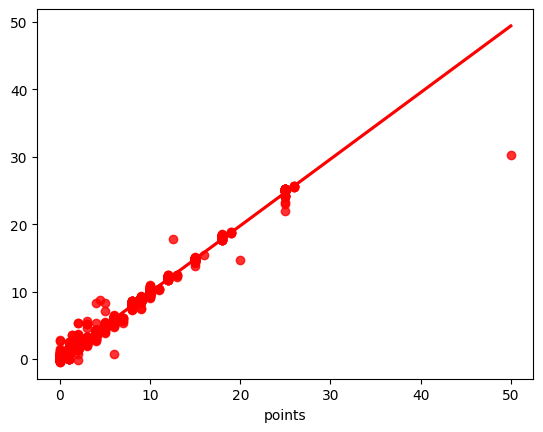

In [16]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

## Summary of regression model building <a id="part9.7"></a>
The best regression model is CatBoosting Regressor, which gives the lowest RMSE score of 0.3284 and highest R-squared value of 0.993784 amongst others.	

## End of Notebook